Good to know
===
This file regroupe some side knwoledge that can be useful at some point... or not. It is basically a sandbox file.

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import ipywidgets as widgets

---

<div align=center>

# RMS (Root Mean Square)

$$
RMS = \sqrt{ \frac{1}{T}\cdot \int_{t_0}^{t_0 + T} x^2(t)\cdot \mathrm{d}t}
$$

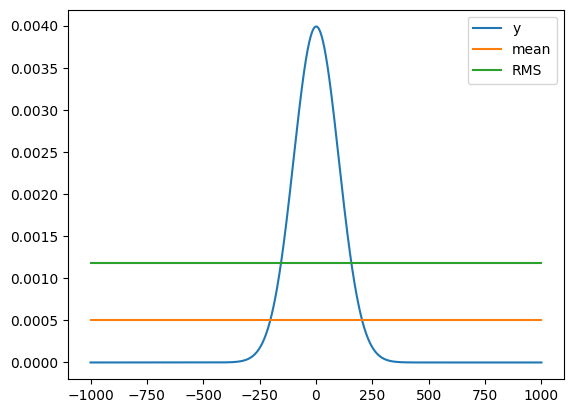

In [5]:
x = np.linspace(-1000,1000,1000)
gaussian = lambda x, mu, sig: 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
y = gaussian(x, 1, 100)
m = np.mean(y)
RMS = np.sqrt(np.mean(y**2))

plt.plot(x, y, label="y")
plt.plot(x, np.ones_like(x)*m, label="mean")
plt.plot(x, np.ones_like(x)*RMS, label="RMS")
plt.legend()
plt.show()

$\rightarrow$ RMS is more sensitive to outliers

$\rightarrow$ In the context of perturbations, the usage of RMS instead of the mean is more relevant because a lower RMS also indicates a lower variance in the perturbations

<div align=center>

---

# Polynôme de Zernike

https://fr.wikipedia.org/wiki/Polyn%C3%B4me_de_Zernike

</div>


Pair:
$$\displaystyle Z_{n}^{m}(\rho ,\varphi )=R_{n}^{m}(\rho )\,\cos(m\,\varphi )\!$$
Impair:
$$\displaystyle Z_{n}^{-m}(\rho ,\varphi )=R_{n}^{m}(\rho )\,\sin(m\,\varphi ),\!$$

Avec:
$$
\displaystyle R_{n}^{m}(\rho )=\sum _{k=0}^{\tfrac {n-m}{2}}{\frac {(-1)^{k}\,(n-k)!}{k!\left({\tfrac {n+m}{2}}-k\right)!\left({\tfrac {n-m}{2}}-k\right)!}}\;\rho ^{n-2k}
$$

- $\rho$ est la distance au centre du disque unité (0 ≤ $\rho$ ≤ 1)
- $\varphi$ est l'angle polaire (0 ≤ $\varphi$ ≤ 2π)
- $n$ et $m$ sont des entiers tels que $n \geq m \geq 0$ et $n-m$ est pair

> A quoi ça sert ? 🤔

Une déformation de front d'onde dû à des aberrations optiques peut être décrite par une combinaison linéaire de polynômes de Zernike. Chaque polynôme de Zernike correspond à une aberration optique particulière.

$$
\displaystyle W(\rho ,\varphi )=\sum _{n=0}^{\infty }\sum _{m=-n}^{n}a_{n}^{m}\,Z_{n}^{m}(\rho ,\varphi )
$$

> Ok, et du coup, ça sert à quoi ? 🤔

Avoir cette forme décomposée (et généralement approximé en prenant un nombre fini de polynômes de Zernike) permet de déterminer formellement comment déformer un front d'onde pour compenser les aberrations optiques.

In [6]:
def zernike(n,m):
    X, Y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
    RHO = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y,X)

    def R(n,m,rho):
        R = np.zeros_like(rho)
        if (n-m)%2==0:
            for k in range((n-np.abs(m))//2+1):
                R += (-1)**k \
                    * math.factorial(n-k) \
                    / (math.factorial(k) \
                    * math.factorial((n+m)//2-k) \
                    * math.factorial((n-m)//2-k)) \
                    * rho**(n-2*k)
        return R
    
    mask = RHO <= 1
    RHO = RHO * mask
    
    return R(n,m,RHO) * np.cos(m*PHI)

n_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='n:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def get_min_max_m(n):
    if n%2==0:
        start = 0
    else:
        start=1
    return -n, n

def get_m_slider():

    start, stop = get_min_max_m(n_slider.value)

    m_slider = widgets.IntSlider(
        value=start,
        min=start,
        max=stop,
        step=2,
        description='m:',
        disabled=True,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    return m_slider

def update_slider_minmax(slider, min, max):

    slider.disabled = False
    if min == max:
        slider.disabled = True
        max += 1

    if min < slider.max:
        slider.min = min
        slider.max = max
        return

    if max > slider.min:
        slider.max = max
        slider.min = min
        return
    
    raise ValueError("min and max are out of range")

m_slider = get_m_slider()

def update_m_slider(change):
    start, stop = get_min_max_m(n_slider.value)
    update_slider_minmax(m_slider, start, stop)
    
    m_slider.value = start

def plot_zernike(n,m):
    plt.title(f"Zernike({n},{m})")
    plt.imshow(zernike(n,m))
    plt.colorbar()
    plt.show()

n_slider.observe(update_m_slider, 'value')
_= widgets.interact(plot_zernike, n=n_slider, m=m_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='n:'), IntSlider(value=0, contin…

<div align=center>

---

# Bruit de photon

</div>


Noise photon power:
$$
\text{NEP}^2 = 2h^2\nu^2\Delta\nu\left(\frac{n}{\eta}+n^2\right)
$$

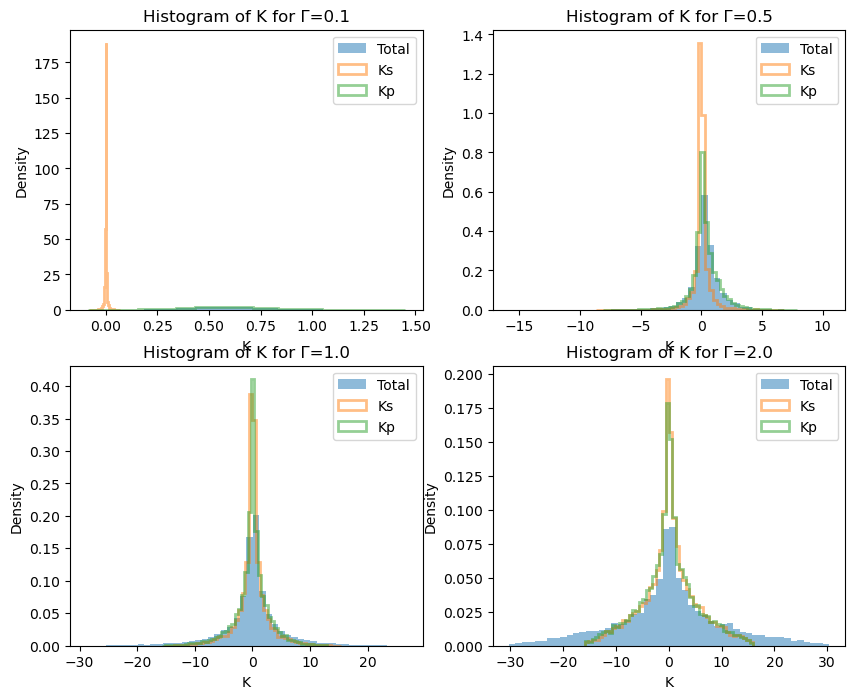

In [7]:
import numpy as np
import matplotlib.pyplot as plt
sin = np.sin
π = np.pi

def get_K(Γ, α=1, β=1, φ2=π/3, φ3=π/4, φ4=π/6, n=10_000):

    # tirage bruit
    σ2 = np.random.normal(0, Γ, n)
    σ3 = np.random.normal(0, Γ, n)
    σ4 = np.random.normal(0, Γ, n)

    # champs étoile
    S1s = α * (1
               + np.exp(1j*(np.pi/2 + σ2))
               + np.exp(1j*(np.pi   + σ3))
               + np.exp(1j*(3*np.pi/2 + σ4)))

    S2s = α * (1
               + np.exp(1j*(3*np.pi/2 + σ2))
               + np.exp(1j*(np.pi     + σ3))
               + np.exp(1j*(np.pi/2   + σ4)))

    # champs planète (avec phases relatives)
    S1p = β * (1
               + np.exp(1j*(np.pi/2 + σ2 + φ2))
               + np.exp(1j*(np.pi   + σ3 + φ3))
               + np.exp(1j*(3*np.pi/2 + σ4 + φ4)))

    S2p = β * (1
               + np.exp(1j*(3*np.pi/2 + σ2 + φ2))
               + np.exp(1j*(np.pi     + σ3 + φ3))
               + np.exp(1j*(np.pi/2   + σ4 + φ4)))

    Ks = np.abs(S1s)**2 - np.abs(S2s)**2
    Kp = np.abs(S1p)**2 - np.abs(S2p)**2


    return Ks, Kp, Ks + Kp

def get_Kbis(Γ, a=1, β=1, φ2=π/3, φ3=π/4, φ4=π/6, n=10_000):
    σ2 = np.random.normal(0, Γ, n)
    σ3 = np.random.normal(0, Γ, n)
    σ4 = np.random.normal(0, Γ, n)
    Ks = 4*a**2 * (-sin(σ2) + sin(σ4) + sin(σ2 - σ3) - sin(σ4 - σ3))
    Kp = 4*β**2 * (-sin(σ2+φ2) + sin(σ4+φ4) + sin(σ2+φ2 - σ3+φ3) - sin(σ4+φ4 - σ3+φ3))

    return Ks, Kp, Ks + Kp

# Plot histogram of K for different values of Γ

Γ_values = [0.1, 0.5, 1.0, 2.0]

plt.figure(figsize=(10, 8))
for i, Γ in enumerate(Γ_values):
    Ks, Kp, Ktot = get_K(Γ)
    plt.subplot(2, 2, i+1)
    plt.hist(Ktot, bins=50, density=True, alpha=0.5, label='Total')
    plt.hist(Ks, bins=50, density=True, alpha=0.5, label='Ks', histtype='step', linewidth=2)
    plt.hist(Kp, bins=50, density=True, alpha=0.5, label='Kp', histtype='step', linewidth=2)
    plt.title(f'Histogram of K for Γ={Γ}')
    plt.xlabel('K')
    plt.ylabel('Density')
    plt.legend()

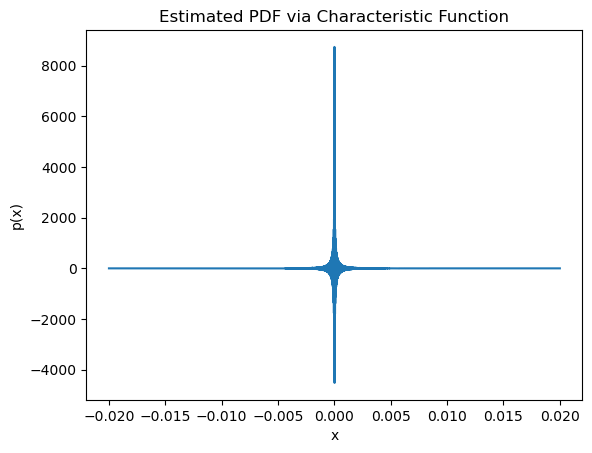

In [8]:
import numpy as np
from numpy.fft import fftshift, ifft, fftfreq

def f(s2,s3,s4):
    return -np.sin(s2) + np.sin(s4) + np.sin(s2 - s3) - np.sin(s4 - s3)

def estimate_pdf_via_cf(a, gamma, x_min, x_max, nx=2048, Nt_phi=200000, t_max=200.0):
    # x-grid
    x = np.linspace(x_min, x_max, nx)
    dx = x[1]-x[0]

    # t-grid for FFT inversion
    dt = 2*np.pi/(nx*dx)
    t = np.linspace(-nx/2, nx/2-1, nx) * dt  # symmetric grid
    # Monte-Carlo to estimate phi_K(t)
    # draw Nt_phi samples and compute e^{itK} average for each t
    # To save memory compute in blocks
    phi = np.zeros(nx, dtype=complex)
    batch = 20000
    n_done = 0
    while n_done < Nt_phi:
        b = min(batch, Nt_phi - n_done)
        s2 = np.random.normal(0, gamma, size=b)
        s3 = np.random.normal(0, gamma, size=b)
        s4 = np.random.normal(0, gamma, size=b)
        K_samples = 4*(a**2) * f(s2[:,None], s3[:,None], s4[:,None])  # shape (b,1)
        # compute e^{i t K} for all t (vectorized via outer product)
        # To be memory-friendly compute for chunks of t
        nchunks = 16
        for i in range(nchunks):
            it0 = i*nx//nchunks
            it1 = (i+1)*nx//nchunks
            Tchunk = t[it0:it1][None,:]  # shape (1,chunk)
            # K_samples is (b,1) -> broadcast
            phi_chunk = np.mean(np.exp(1j * Tchunk * K_samples), axis=0)
            phi[it0:it1] += phi_chunk * b
        n_done += b

    phi /= Nt_phi  # average over all samples

    # invert characteristic function (Fourier transform)
    # p(x) = (1/2pi) \int e^{-i t x} phi(t) dt
    # we have phi on t-grid -> use FFT with proper shifts/scaling
    phi_shifted = fftshift(phi)  # align for FFT
    px = fftshift(ifft(np.fft.ifftshift(phi_shifted))) * len(t) * dt / (2*np.pi)
    px = np.real(px)  # should be real (up to numerical error)

    return x, px

# Ex: usage
a = 1.0
gamma = 0.05
x, px = estimate_pdf_via_cf(a, gamma, x_min=-0.02, x_max=0.02, nx=4096, Nt_phi=200000, t_max=200.)
# then plot x vs px

import matplotlib.pyplot as plt
plt.plot(x, px)
plt.xlabel('x')
plt.ylabel('p(x)')
plt.title('Estimated PDF via Characteristic Function')
plt.show()

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

def pK(x, α, β, φ2, φ3, φ4, Γ, nsamples=200_000):
    """
    Renvoie la densité de probabilité p(K = x) estimée par KDE.

    Paramètres
    ----------
    x : float ou array
        Valeurs où évaluer la densité.
    α : float
        Amplitude de l'étoile (champ égal sur les 4 télescopes).
    β : float
        Amplitude de la planète.
    φ2, φ3, φ4 : floats
        Phases de la planète pour chaque entrée.
    Γ : float
        RMS des erreurs de phase sigma.
    nsamples : int
        Nombre d'échantillons Monte-Carlo.

    Retour
    ------
    pdf : array
        pK(x, ...) évaluée aux points x.
    """

    # tirage bruit
    σ2 = np.random.normal(0, Γ, nsamples)
    σ3 = np.random.normal(0, Γ, nsamples)
    σ4 = np.random.normal(0, Γ, nsamples)

    # champs étoile
    S1s = α * (1
               + np.exp(1j*(np.pi/2 + σ2))
               + np.exp(1j*(np.pi   + σ3))
               + np.exp(1j*(3*np.pi/2 + σ4)))

    S2s = α * (1
               + np.exp(1j*(3*np.pi/2 + σ2))
               + np.exp(1j*(np.pi     + σ3))
               + np.exp(1j*(np.pi/2   + σ4)))

    # champs planète (avec phases relatives)
    S1p = β * (1
               + np.exp(1j*(np.pi/2 + σ2 + φ2))
               + np.exp(1j*(np.pi   + σ3 + φ3))
               + np.exp(1j*(3*np.pi/2 + σ4 + φ4)))

    S2p = β * (1
               + np.exp(1j*(3*np.pi/2 + σ2 + φ2))
               + np.exp(1j*(np.pi     + σ3 + φ3))
               + np.exp(1j*(np.pi/2   + σ4 + φ4)))

    K = np.abs(S1s)**2 - np.abs(S2s)**2 + np.abs(S1p)**2 - np.abs(S2p)**2

    kde = gaussian_kde(K)
    return kde(x)


In [ ]:
# Build GUI with sliders to adjust parameters and see the effect on the PDF
import ipywidgets as widgets
α_slider = widgets.FloatSlider(value=1, min=0.01, max=2.0, step=0.01, description='α:')
β_slider = widgets.FloatSlider(value=0.5, min=0.01, max=2.0, step=0.01, description='β:')
φ2_slider = widgets.FloatSlider(value=0.4, min=0.0, max=2*np.pi, step=0.01, description='φ2:')
φ3_slider = widgets.FloatSlider(value=1.1, min=0.0, max=2*np.pi, step=0.01, description='φ3:')
φ4_slider = widgets.FloatSlider(value=2.3, min=0.0, max=2*np.pi, step=0.01, description='φ4:')
Γ_slider = widgets.FloatSlider(value=1.0, min=0.01, max=5.0, step=0.01, description='Γ:')

def update_pdf(α, β, φ2, φ3, φ4, Γ):
    Ks, Kp, Ktot = get_K(Γ=Γ, α=α, β=β, φ2=φ2, φ3=φ3, φ4=φ4, n=100000)
    x = np.linspace(np.min(Ktot), np.max(Ktot), 1000)
    
    plt.figure(figsize=(8,5))
    plt.plot(x, pK(x, α=α, β=β, φ2=φ2, φ3=φ3, φ4=φ4, Γ=Γ), label='PDFtot')
    plt.hist(Ktot, bins=50, density=True, alpha=0.5, label='Histogram of Ktot')
    # plt.hist(Ks, bins=50, density=True, alpha=0.5, label='Histogram of Ks', histtype='step', linewidth=2)
    # plt.plot(x, pK(x, α=α, β=0, φ2=φ2, φ3=φ3, φ4=φ4, Γ=Γ), label='PDFKs')
    # plt.hist(Kp, bins=50, density=True, alpha=0.5, label='Histogram of Kp', histtype='step', linewidth=2)
    # plt.plot(x, pK(x, α=0, β=β, φ2=φ2, φ3=φ3, φ4=φ4, Γ=Γ), label='PDFKp')
    
    plt.hist(Ks + Kp, bins=50, density=True, alpha=0.5, label='Histogram of Ks + Kp', histtype='step', linewidth=2)
    plt.xlabel("K")
    plt.ylabel("p(K)")
    plt.title("PDF of K with Tunable Parameters")
    plt.legend()
    plt.grid()
    plt.show()

widgets.interact(update_pdf, α=α_slider, β=β_slider, φ2=φ2_slider, φ3=φ3_slider, φ4=φ4_slider, Γ=Γ_slider)

interactive(children=(FloatSlider(value=1.0, description='α:', max=2.0, min=0.01, step=0.01), FloatSlider(valu…

<function __main__.update_pdf(α, β, φ2, φ3, φ4, Γ)>